# Chapter 10 
 Industrial Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (2023) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [25]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Bayesian Reliability Estimation and Prediction

In [2]:
import random
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import gamma
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import mistat
import lifelines

import arviz as az
import pymc as pm
from aesara import tensor as T

## Prior and Posterior Distributions

In [3]:
from mistat import bayes

betaMixture = bayes.Mixture(
    probabilities=[0.5, 0.5],
    distributions=[bayes.BetaDistribution(a=1, b=1),
                   bayes.BetaDistribution(a=15, b=2)])
data = [10, 2]
result = bayes.updateBetaMixture(betaMixture, data)
thetas = [round(d.theta(), 2) for d in result.distributions]

print(f'A posteriori: {result.probabilities}')
print(f'Updated beta distributions:\n{result.distributions}')
print(f'Update theta values:\n{thetas}')

A posteriori: [0.2845528455284548, 0.7154471544715452]
Updated beta distributions:
[BetaDistribution(a=11, b=3), BetaDistribution(a=25, b=4)]
Update theta values:
[0.79, 0.86]


In [4]:
mixture = bayes.Mixture(
    probabilities=[0.5, 0.5],
    distributions=[
        bayes.GammaDistribution(shape=1, rate=1),
        bayes.GammaDistribution(shape=15, rate=2),
    ]
)
data = {'y': [5], 't': [1]}
result = bayes.updateGammaMixture(mixture, data)

print(f'A posteriori: {result.probabilities}')
print(f'Updated beta distributions:\n{result.distributions}')

A posteriori: [0.1250977996957064, 0.8749022003042937]
Updated beta distributions:
[GammaDistribution(shape=6, rate=2), GammaDistribution(shape=20, rate=3)]


## Loss Functions and Bayes Estimators

### Distribution-Free Bayes Estimator of Reliability

### Bayes Estimator of Reliability for Exponential Life Distributions

## Bayesian Credibility and Prediction Intervals

### Distribution-Free Reliability Estimation

### Exponential Reliability Estimation

### Prediction Intervals

### Applications with Python: Lifelines and pymc

In [5]:
systemFailure = mistat.load_data('SYSTEMFAILURE')
systemFailure['Time stamp'] = systemFailure['Time stamp'] / 1_000_000 
systemFailure['Young'] = [0 if v == 'Mature' else 1 
                          for v in systemFailure['System Maturity']]
systemFailure = systemFailure[['Time stamp', 'Censor', 'Young']]
systemFailure.head()

,Time stamp,Censor,Young
0,1.574153,1,0
1,2.261043,0,0
2,1.726097,1,0
3,1.178089,1,0
4,1.354856,1,0


In [6]:
kmf = lifelines.WeibullFitter()
kmf.fit(systemFailure['Time stamp'], event_observed=systemFailure['Censor']==0)
print(f'Scale: {kmf.lambda_:.3f}')
print(f'Shape: {kmf.rho_:.4f}')

Scale: 4.351
Shape: 0.7226


In [7]:
kmf.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 140 right-censored observations>
   number of observations = 208
number of events observed = 68
           log-likelihood = -141.61
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%
lambda_   4.35       0.91             2.57             6.13
rho_      0.72       0.08             0.57             0.87

          cmp to     z      p   -log2(p)
lambda_     1.00  3.69 <0.005      12.13
rho_        1.00 -3.67 <0.005      12.01
---
AIC = 287.22

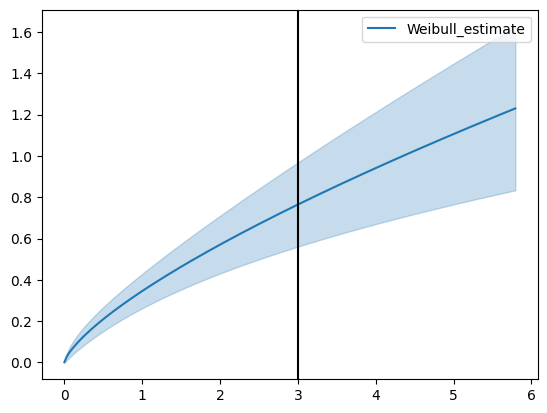

In [8]:
ax = kmf.plot()
ax.axvline(3, color='black')
plt.show()

In [9]:
failureRate = 1 - kmf.predict(3_000_000 / 1_000_000)
ciCumDensity = kmf.confidence_interval_cumulative_density_
fr_low, fr_high = ciCumDensity[ciCumDensity.index > 3].iloc[0,]

print('Parameteric model:')
print(f'Mean of failure rates at 3,000,000: {failureRate:.3f}')
print(f'95%-confidence interval at 3,000,000: [{fr_low:.3f}, {fr_high:.3f}]')

Parameteric model:
Mean of failure rates at 3,000,000: 0.534
95%-confidence interval at 3,000,000: [0.441, 0.632]


In [10]:
def weibull_log_sf(y, nu, beta):
    return - (y / beta) ** nu

In [11]:
# extract observed and censored observations a numpy arrays
censored = systemFailure['Censor'].values == 1
y_observed = systemFailure['Time stamp'][~censored].values
y_censored = systemFailure['Time stamp'][censored].values

with pm.Model() as weibull_model_uninformative:
    beta = pm.Uniform('beta', lower=0.5, upper=10) # scale
    nu = pm.Uniform('nu', lower=0.5, upper=1.1) # shape
    
    y_obs = pm.Weibull('y_obs', alpha=nu, beta=beta, observed=y_observed)
    y_cens = pm.Potential('y_cens', weibull_log_sf(y_censored, nu, beta))

In [12]:
with weibull_model_uninformative:
    trace_uninformative = pm.sample(1000, random_seed=123, progressbar=False,
                     return_inferencedata=True)

/usr/local/lib/python3.9/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, nu]
Sampl

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


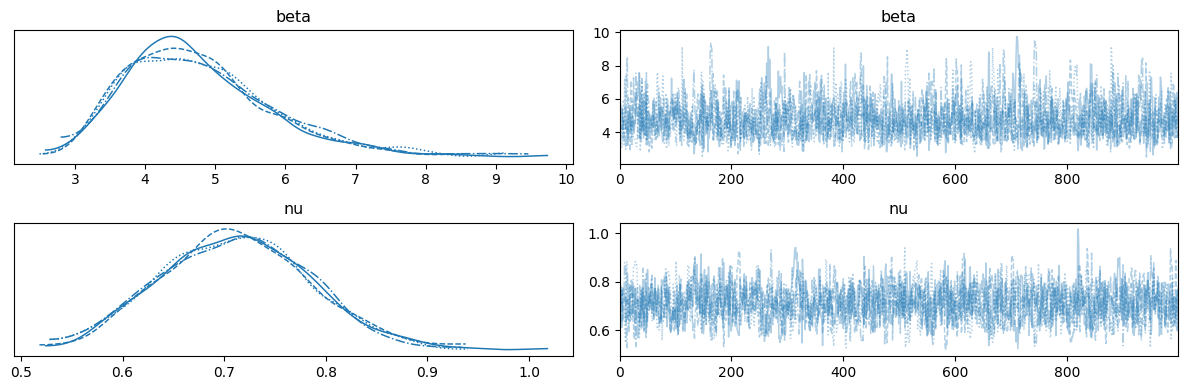

In [13]:
with weibull_model_uninformative:
    az.plot_trace(trace_uninformative)
plt.tight_layout()

Sampling: [beta, nu]


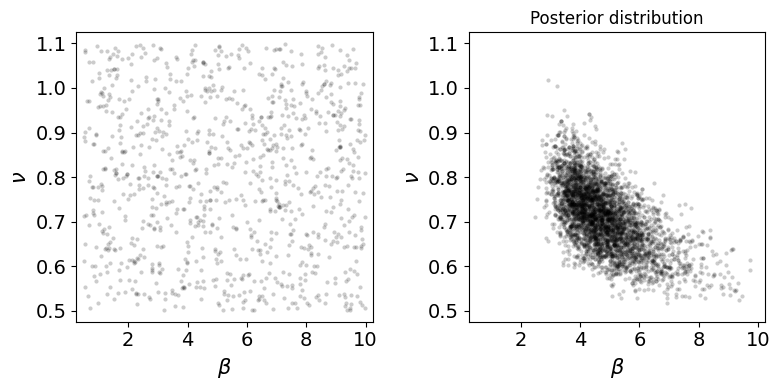

In [14]:
with weibull_model_uninformative:
    prior_checks = pm.sample_prior_predictive(samples=1000, random_seed=123, var_names=['nu', 'beta'])

fig, axes = plt.subplots(ncols=2, figsize=[8, 4])
az.plot_pair(prior_checks.prior, ax=axes[0], var_names=['beta', 'nu'], scatter_kwargs={'alpha': 0.2, 'color': 'black'})
axes[1].set_title('Prior distribution')
az.plot_pair(trace_uninformative, ax=axes[1], var_names=['beta', 'nu'], scatter_kwargs={'alpha': 0.2, 'color': 'black'})
axes[1].set_title('Posterior distribution')
for ax in axes:
    ax.set_xlim(0.25, 10.25)
    ax.set_ylim(0.475, 1.125)
    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'$\nu$')
plt.tight_layout()
plt.show()

In [15]:
with pm.Model() as weibull_model_informative:
    beta = pm.Gamma('beta', alpha=4.5 * 7, beta=7) # scale
    nu = pm.Gamma('nu', alpha=0.7 * 100, beta=100) #shape
    
    y_obs = pm.Weibull('y_obs', alpha=nu, beta=beta, observed=y_observed)
    y_cens = pm.Potential('y_cens', weibull_log_sf(y_censored, nu, beta))

    trace_informative = pm.sample(1000, random_seed=123, progressbar=False,
                     return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, nu]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


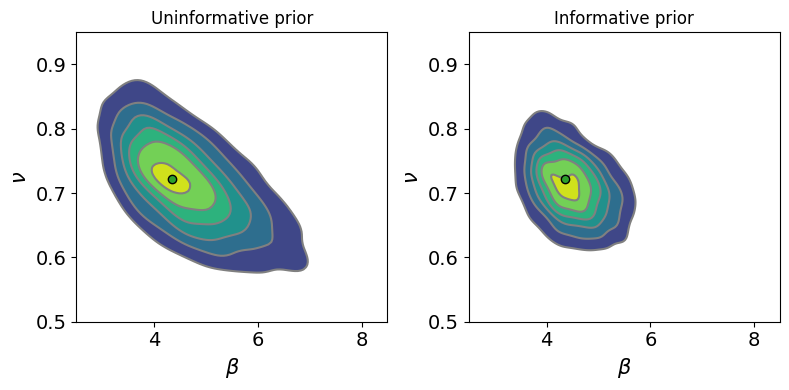

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=[8, 4])
az.plot_pair(trace_uninformative, kind='kde', ax=axes[0], var_names=['beta', 'nu'],
             reference_values={'beta': kmf.lambda_, 'nu': kmf.rho_})
axes[0].set_title('Uninformative prior')
az.plot_pair(trace_informative, kind='kde', ax=axes[1], var_names=['beta', 'nu'],
             reference_values={'beta': kmf.lambda_, 'nu': kmf.rho_})
axes[1].set_title('Informative prior')
for ax in axes:
    ax.set_xlim(2.5, 8.5)
    ax.set_ylim(0.5, 0.95)
    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'$\nu$')
plt.tight_layout()

In [17]:
def sampleFailureRates(model, model_trace, nu_var='nu', beta_var='beta'):
    t_plot = np.linspace(0, 10, 101)
    t_plot[0] = 0.00001 
    with model:
        pp_trace = pm.sample_posterior_predictive(model_trace, 
            var_names=[nu_var, beta_var], progressbar=False, random_seed=123)
    sampled = az.extract(pp_trace.posterior_predictive)
    curves = [stats.weibull_min.cdf(t_plot, nu, scale=beta) 
             for beta, nu in zip(sampled[beta_var], sampled[nu_var])]
    curves = np.array(curves)
    return {'time': t_plot, 'failure_rates': curves,
           'mean_failure_rate': np.mean(curves, axis=0)}

In [18]:
def estimatedFailureRate(failureRates, at_time=3.0):
    idx = np.argmax(failureRates['time'] >= at_time)
    curves = failureRates['failure_rates']
    failure_rate = np.mean(curves, axis=0)[idx]
    print(f'Mean of failure rates at 3,000,000: {failure_rate:.3f}')
    hdi_95 = az.hdi(np.array(curves), hdi_prob=0.95)[idx,:]
    print(f'95%-HPD at 3,000,000: {hdi_95.round(3)}')
    return failure_rate

In [19]:
sampledCurves = sampleFailureRates(weibull_model_uninformative, 
                                   trace_uninformative)
_ = estimatedFailureRate(sampledCurves)


sampledCurvesInformative = sampleFailureRates(weibull_model_informative, 
                                              trace_informative)
_ = estimatedFailureRate(sampledCurvesInformative)

Sampling: [beta, nu]
Sampling: [beta, nu]


Mean of failure rates at 3,000,000: 0.532
95%-HPD at 3,000,000: [0.252 0.923]
Mean of failure rates at 3,000,000: 0.534
95%-HPD at 3,000,000: [0.446 0.625]


Mean of failure rates at 3,000,000: 0.534
95%-HPD at 3,000,000: [0.446 0.625]


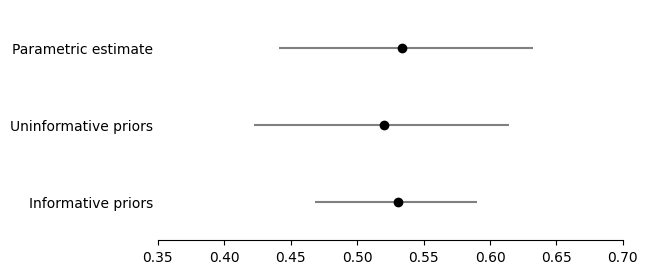

In [20]:
results = pd.DataFrame({
    'Parametric estimate': [0.534, 0.441, 0.632],
    'Uninformative priors': [0.520, 0.422, 0.614],
    'Informative priors': [0.531, 0.468, 0.59],
}, index=['Mean', 'low', 'high']).transpose()

fig, ax = plt.subplots(figsize=(6, 3))
labels = []
ticks = []
# ax.scatter(results['Mean'], range(3), color='black')
for i, (name, row) in enumerate(results.iterrows()):
    ax.hlines(-i, row['low'], row['high'], color='grey')
    ax.scatter(row['Mean'], -i, color='black', zorder=10)
    labels.append(name)
    ticks.append(-i)
ax.set_yticks(ticks, labels)
ax.set_xlim(0.35, 0.7)
ax.set_ylim(-2.5, 0.5)
ax.tick_params(axis='y', which='both',length=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [21]:
# split the events both by their censored and young status
censored = systemFailure['Censor'].values == 1
young = systemFailure['Young'].values == 1

y_observed = systemFailure['Time stamp'][~censored & ~young].values
y_censored = systemFailure['Time stamp'][censored & ~young].values
y_observed_young = systemFailure['Time stamp'][~censored & young].values
y_censored_young = systemFailure['Time stamp'][censored & young].values

with pm.Model() as weibull_model_maturity:
    beta = pm.Uniform('beta', lower=0.5, upper=10) # scale
    nu = pm.Uniform('nu', lower=0.5, upper=1.1) # shape
    beta_young = pm.Uniform('beta_young', lower=0, upper=10) # scale
    nu_young = pm.Uniform('nu_young', lower=0, upper=1.1) # shape
    
    y_obs = pm.Weibull('y_obs', alpha=nu, beta=beta, observed=y_observed)
    y_cens = pm.Potential('y_cens', weibull_log_sf(y_censored, nu, beta))
    y_obs_young = pm.Weibull('y_obs_young', alpha=nu_young, beta=beta_young, 
            observed=y_observed_young)
    y_cens_young = pm.Potential('y_cens_young', weibull_log_sf(y_censored_young, 
                                                     nu_young, beta_young))    

    trace_maturity = pm.sample(2000, tune=3500, random_seed=123, 
          progressbar=False, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, nu, beta_young, nu_young]
Sampling 4 chains for 3_500 tune and 2_000 draw iterations (14_000 + 8_000 draws total) took 12 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, nu, beta_young, nu_young]


Sampling 4 chains for 3_500 tune and 2_000 draw iterations (14_000 + 8_000 draws total) took 11 seconds.


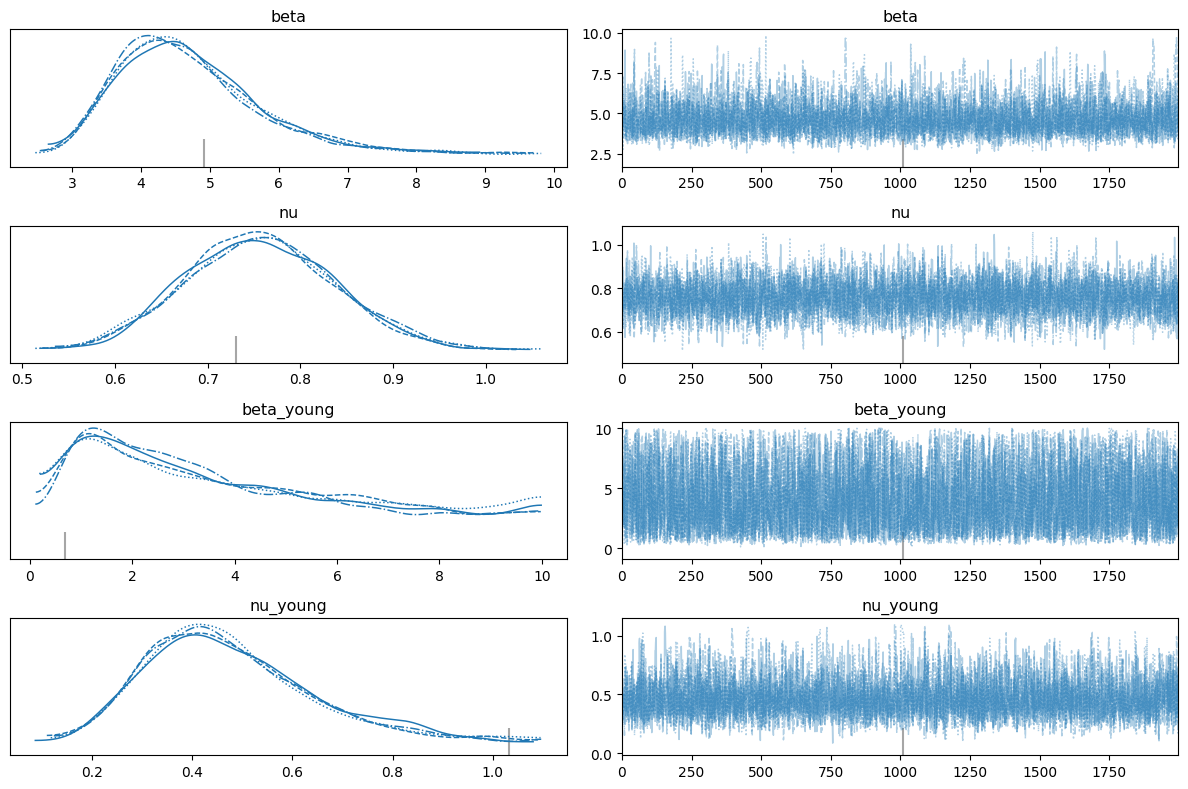

In [22]:
with weibull_model_uninformative:
    az.plot_trace(trace_maturity)
plt.tight_layout()

In [23]:
sampledCurvesMature = sampleFailureRates(weibull_model_maturity, trace_maturity)
sampledCurvesYoung = sampleFailureRates(weibull_model_maturity, trace_maturity,
                                        nu_var='nu_young', beta_var='beta_young')

print('Mature system')
_ = estimatedFailureRate(sampledCurvesMature)
print('Young system')
_ = estimatedFailureRate(sampledCurvesYoung)

Sampling: [beta, nu]
Sampling: [beta_young, nu_young]


Mature system
Mean of failure rates at 3,000,000: 0.531
95%-HPD at 3,000,000: [0.25  0.917]
Young system
Mean of failure rates at 3,000,000: 0.581
95%-HPD at 3,000,000: [0.324 1.   ]


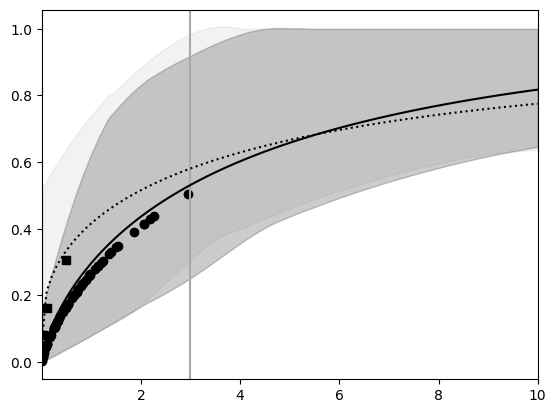

In [24]:
timepoints = sampledCurvesMature['time']

ax = az.plot_hdi(timepoints, sampledCurvesMature['failure_rates'], hdi_prob=0.95,
                 fill_kwargs={'color': 'black', 'alpha': 0.2})
ax = az.plot_hdi(timepoints, sampledCurvesYoung['failure_rates'], hdi_prob=0.95, ax=ax, 
                 fill_kwargs={'color': 'grey', 'alpha': 0.1})
ax.axvline(3, color='darkgrey')
ax.plot(timepoints, sampledCurvesMature['mean_failure_rate'], color='black')
ax.plot(timepoints, sampledCurvesYoung['mean_failure_rate'], color='black', linestyle=':')
ax.set_xlim(0.001, 10)
# ax.set_ylim(0.001, 10)
# ax.set_xscale('log')
# ax.set_yscale('log')

# overlay the observed failures
def overlayObserved(y, beta, nu, ax, marker='o', color='black'):
    fr = stats.weibull_min.cdf(y, nu, scale=beta)
    ax.scatter(y, fr, color=color, marker=marker)    
meanPara = az.summary(trace_maturity)['mean']
overlayObserved(y_observed, meanPara['beta'], meanPara['nu'], ax)
overlayObserved(y_observed_young, meanPara['beta_young'], meanPara['nu_young'], ax, marker='s')

plt.show()

## Credibility Intervals for the Asymptotic Availability of Repairable Systems: The Exponential Case

## Empirical Bayes Method

## Chapter Highlights

## Exercises